In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Load Fashon MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
class_names = np.asarray(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

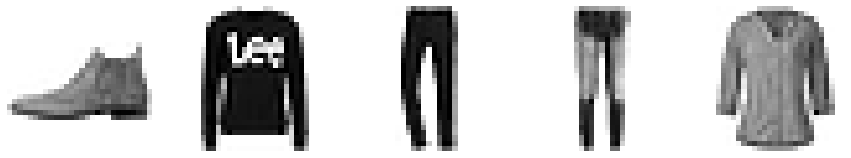

In [7]:
# Display a few examples

n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15,4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [10]:
# Define the encoder

encoded_dim = 2

encoder = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(encoded_dim)
])

In [11]:
# Encode examples before training

pretrain_example_encodings = encoder(example_images).numpy()

/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


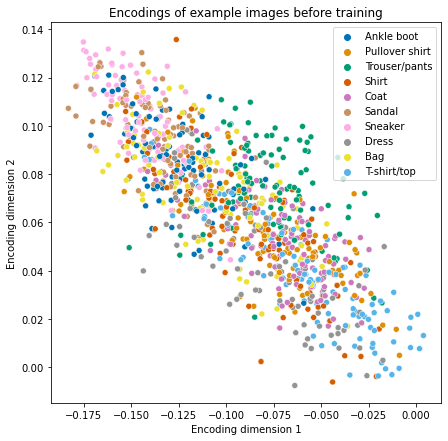

In [13]:
# Plot encoded examples before training

f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(pretrain_example_encodings[:,0],
               pretrain_example_encodings[:,1],
               hue=class_names[example_labels], ax=ax,
               palette=sns.color_palette('colorblind', 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

It is difficult to see what kind of images are mapped to the different regions of the encoding space. We can see that the newly initialized encoder does not disentangle the various classes. 

In [14]:
# Define the decoder

decoder = Sequential([
    Dense(64, activation='sigmoid', input_shape=(encoded_dim,)),
    Dense(256, activation='sigmoid'),
    Dense(28*28, activation='sigmoid'),
    Reshape((28,28))
])

In [16]:
# Compile and fit the model

autoencoder = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

# Specify loss - input and output is in [0.,1.], so we can use a binary cross-entropy loss

autoencoder.compile(loss='binary_crossentropy')

# Fit the model - highligh that labels and input are the same
autoencoder.fit(x=x_train, y=x_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4345
Epoch 2/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3457
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3339
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3301
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3259
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3248
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3232
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3225
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3209
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3203


In [18]:
# Compute example encodings after training

posttrain_example_encodings= encoder(example_images).numpy()

/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


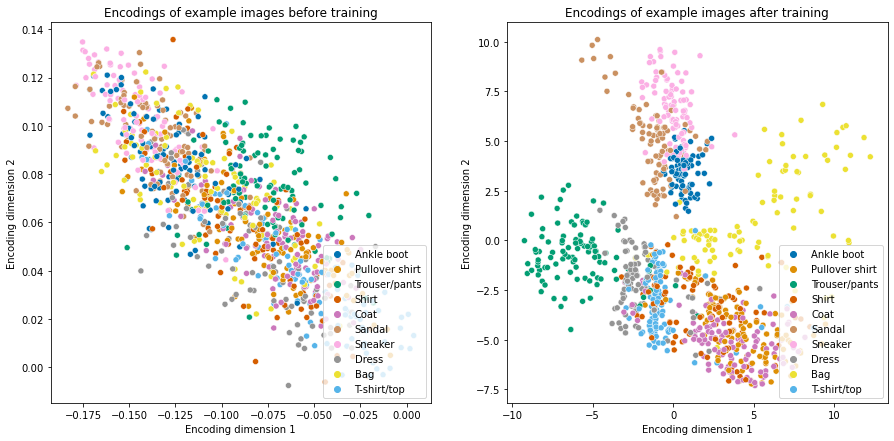

In [23]:
# Plot encoded examples before training

f, axs = plt.subplots(1, 2, figsize=(15,7))
sns.scatterplot(pretrain_example_encodings[:,0],
               pretrain_example_encodings[:,1],
               hue=class_names[example_labels], ax=axs[0],
               palette=sns.color_palette('colorblind', 10));
sns.scatterplot(posttrain_example_encodings[:,0],
               posttrain_example_encodings[:,1],
               hue=class_names[example_labels], ax=axs[1],
               palette=sns.color_palette('colorblind', 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');


for ax in axs:
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')

Despite not using the labels for training, the autoencoder provides a fairly good separation of the classes. This is particularly the case for classes where the feature vectors are very different, for example, the encoder does not separate well coats and shirts but does separate them from boots and sandals.

In [24]:
# Compute the autoencoder's reconstruction

reconstructed_example_images = autoencoder(example_images)

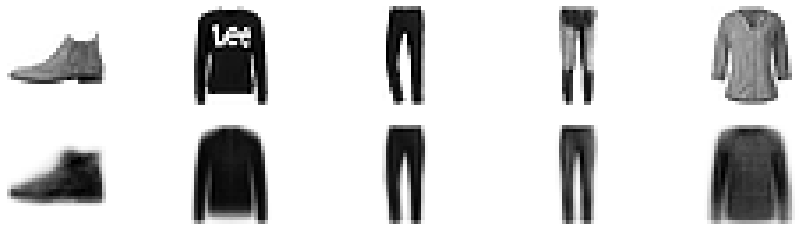

In [25]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

The image properties such as shape and color are successfully reconstructed while details that are particular to individual images, such as logos and decoration are not.